In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from fredapi import Fred
from datetime import datetime
import pandas_datareader.data as web

## Stock price and interest rates

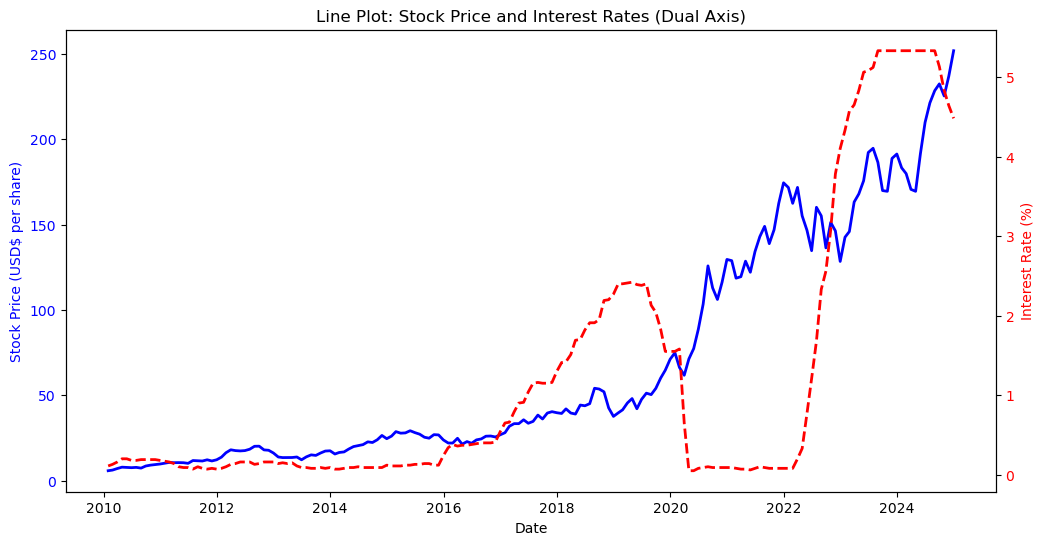

In [194]:
# Fetch data
firm = yf.Ticker("AAPL")
firm_data = firm.history(start="2010-01-01", end="2024-12-31")
rates = pdr.DataReader("FEDFUNDS", "fred", "2010-01-01", "2024-12-31")

# Remove timezone info from both firm_data and rates
firm_data.index = firm_data.index.tz_localize(None)
rates.index = rates.index.tz_localize(None)

# Resample firm data to monthly frequency, taking the last available price of the month
df = firm_data['Close'].resample('M').last() 

# Fetch the FEDFUNDS rate and align it with the resampled firm data
df_rates = rates['FEDFUNDS'].resample('M').last() 

# Combine both datasets into one dataframe
df = pd.DataFrame({'Close': df, 'Rate': df_rates})

# Forward fill missing values (if any) using the correct method
df['Rate'] = df['Rate'].ffill()
df['Close'] = df['Close'].ffill()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the stock price on the first y-axis
ax1.plot(df.index, df['Close'], label='Stock Price (AAPL)', color='blue', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price (USD$ per share)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the interest rate
ax2 = ax1.twinx()
ax2.plot(df.index, df['Rate'], label='Interest Rate (FEDFUNDS)', color='red', linestyle='--', linewidth=2)
ax2.set_ylabel('Interest Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Line Plot: Stock Price and Interest Rates (Dual Axis)')

plt.savefig("stocks.png", dpi=300)

plt.show()


## Revenue vs Interest rates

In [180]:
msft = yf.Ticker("LOW")
revenue_df = msft.financials.loc["Total Revenue"].T  # Transpose for time across rows
# Get Fed Funds Rate from FRED
start = datetime(2015, 1, 1)
end = datetime(2025, 1, 1)
rates = web.DataReader('FEDFUNDS', 'fred', start, end)

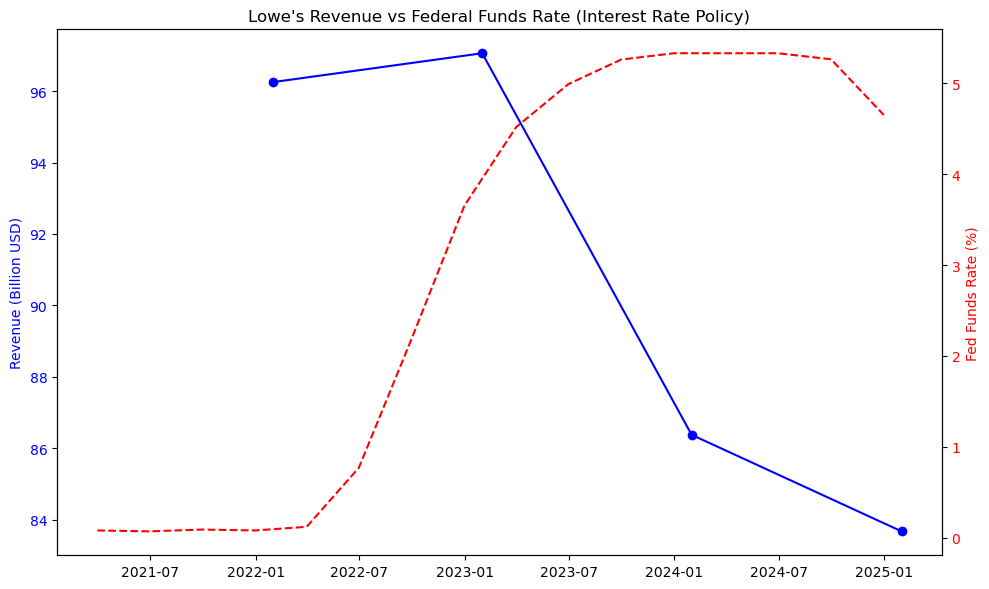

In [181]:
revenue = revenue_df/ 1e9  # Convert to billions
revenue.index = pd.to_datetime(revenue.index)

rates_q = rates.resample('Q').mean()
rates_q = rates_q.loc[revenue.index.min():revenue.index.max()] 

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Revenue line
ax1.plot(revenue.index, revenue.values, color='blue', marker='o', label='Revenue (Billion $)')
ax1.set_ylabel('Revenue (Billion USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Interest Rate on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(rates_q.index, rates_q['FEDFUNDS'], color='red', linestyle='--', label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Lowe's Revenue vs Federal Funds Rate (Interest Rate Policy)")
fig.tight_layout()
plt.savefig("Lowe's.png", dpi=300) 
plt.show()

## Unemployment and interest rates

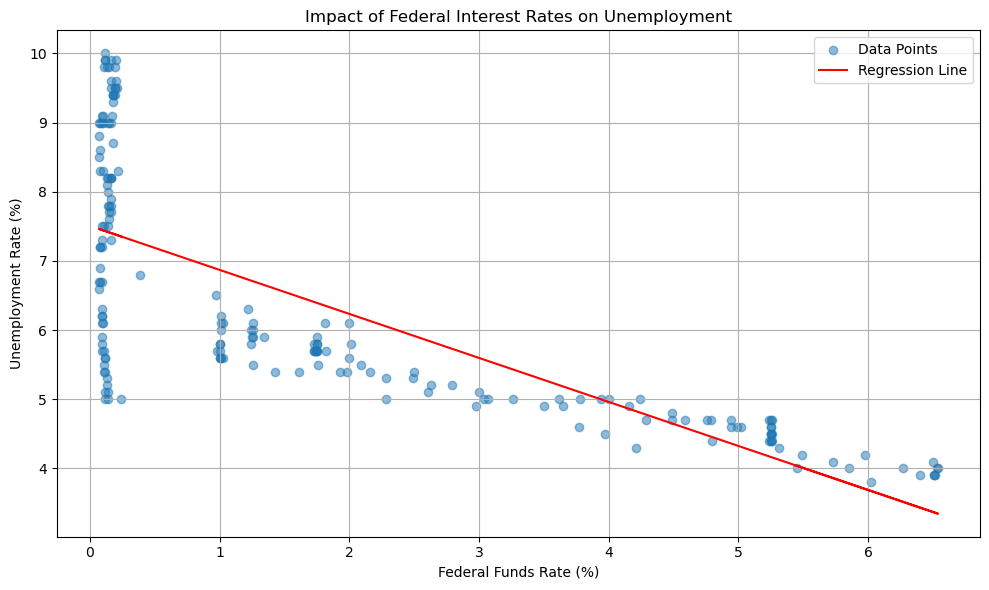

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     247.4
Date:                Tue, 13 May 2025   Prob (F-statistic):           3.03e-36
Time:                        22:37:47   Log-Likelihood:                -302.08
No. Observations:                 192   AIC:                             608.2
Df Residuals:                     190   BIC:                             614.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5062      0.114     65.751      0.0

In [189]:
start = "2000-01-01"
end = "2015-12-31"

# Get Federal Funds Rate and Unemployment Rate
rate = web.DataReader("FEDFUNDS", "fred", start, end)
unemployment = web.DataReader("UNRATE", "fred", start, end)

# Merge datasets
df = pd.merge(rate, unemployment, left_index=True, right_index=True)
df.columns = ["Rate", "Unemployment"]
df.dropna(inplace=True)

# Regression analysis
X = sm.add_constant(df["Rate"])
y = df["Unemployment"]
model = sm.OLS(y, X)
results = model.fit()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df["Rate"], df["Unemployment"], alpha=0.5, label="Data Points")
plt.plot(df["Rate"], results.predict(X), color="red", label="Regression Line")
plt.xlabel("Federal Funds Rate (%)")
plt.ylabel("Unemployment Rate (%)")
plt.title("Impact of Federal Interest Rates on Unemployment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("unemployment.png", dpi=300)
plt.show()

print(results.summary())

## Operating Expense and Interest rates 

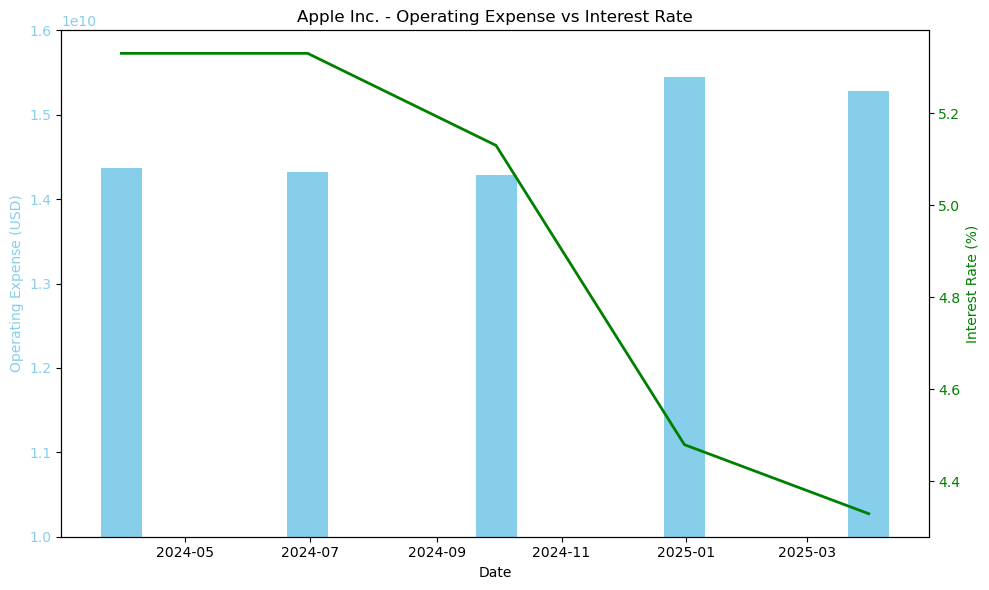

In [193]:
# --- 1. Fetch R&D Spending for Apple ---
ticker = yf.Ticker("AAPL") 
# Quarterly financials
financials = ticker.quarterly_financials.T

# Extract R&D and date
rd = financials['Operating Expense'].copy() 
rd = rd.sort_index()
rd.index = pd.to_datetime(rd.index)
rd = rd.resample("Q").last() 

# --- 2. Fetch Fed Funds Rate (Interest Rate) ---
rates = pdr.DataReader("FEDFUNDS", "fred", rd.index.min(), rd.index.max())
rates = rates.resample("Q").last()  # Resample to quarterly data

# --- 3. Merge DataFrames ---
df = pd.merge(rd, rates, left_index=True, right_index=True)
df.columns = ['Operating Expense', 'Interest Rate']  

# Drop any missing values
df.dropna(inplace=True)

df = df.astype(float)

# --- 4. Plotting the data (Bar for R&D, Line for Interest Rate) ---
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df.index, df['Operating Expense'], width=20, label='Operating Expense', color='skyblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Operating Expense (USD)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
# Set y-axis limit for Operating Expense (R&D)
ax1.set_ylim(10000000000, 16000000000) 

# Interest Rate as a line plot on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['Interest Rate'], label='Interest Rate (%)', color='green', linewidth=2)
ax2.set_ylabel('Interest Rate (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title(f'{ticker.info["longName"]} - Operating Expense vs Interest Rate')
fig.tight_layout()
plt.savefig("Operating_R&D.png", dpi=300)
plt.show()